## fastMRI multi-label classifier

This is a pretext task so that the classifier learns features useful in reconstructing a slice from neighboring slices. 

Task:

- Input x: a sequence of neighboring MR slices $abcde$ in shuffled order (such as $dabce$)
- Target y: a pair-wise classification of which slices come earlier in the sequence.

It is exactly analagous to giving as input a clip of randomly shuffled movie scenes and asking the classifier to put the scenes in the correct time-order.

Example:

Suppose we have 5 neighboring slices $abcde$. We shuffle and give as input the 5 slices in the order of $dabce$. Looking at the features in the slices, the classifier should figure out that the slice labelled $a$ (at index 1 in the input) should actually come before slice $a$ (at index 0 in the input). The full target label is:

| Pair (indices) | Pair (values at index) | Which Comes First? | Label (Is pair out-of-order?) |
|----------------|------------------------|--------------------|--------------------------------|
| (0,1)          | d vs a                 | a                  | 1                              |
| (0,2)          | d vs b                 | b                  | 1                              |
| (0,3)          | d vs c                 | c                  | 1                              |
| (0,4)          | d vs e                 | d                  | 0                              |
| (1,2)          | a vs b                 | a                  | 0                              |
| (1,3)          | a vs c                 | a                  | 0                              |
| (1,4)          | a vs e                 | a                  | 0                              |
| (2,3)          | b vs c                 | b                  | 0                              |
| (2,4)          | b vs e                 | b                  | 0                              |
| (3,4)          | c vs e                 | c                  | 0                              |

Note: I do pair-wise classification because it yields a granular loss function: given that the target answer is $1110000000$, clearly $1100000000$ is a much better prediction than $0000111111$. The loss function is simply binary cross-entropy with respect to the pairwise labels -- each predicted value in the label can be interpreted as the probability of those two slices being out-of-order.

Potential Trouble: perhaps it only learns relatize sizes and not more relevant anatomy features that describe which slice comes first?

## Setup

In [1]:
from google.colab import drive
from pathlib      import Path 

PROJ = "fastmri"

DO_GDRIVE_SETUP = True
DO_GITHUB_SETUP = False

In [2]:
def run_setup_helpers(path):
  %run "$path/common_constants_env.ipynb" # pip install fastai, fastmri, etc
  %run "$path/04_kspace_tfms.ipynb"       # get the kspace tfms

In [3]:
if DO_GDRIVE_SETUP:
  ROOT = "/content/drive"     # default location for the drive
  drive.mount(ROOT)           # mount google drive at /content/drive
  
  G_PATH = Path(ROOT)/"My Drive/fastai_proj/"/PROJ  # GDRIVE path
  G_PATH.mkdir(parents=True, exist_ok=True)
  run_setup_helpers(G_PATH)

if DO_GITHUB_SETUP:
  !git clone https://github.com/RGologorsky/fastmri.git
  run_setup_helpers(PROJ)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
pip install fastai2
git clone fastMRI
pip install ISMRMRD
pip install fasMRI req
pip install runstats
sys append /content/fastMRI - for transforms T, evaluation metrics E
imports


In [4]:
# %run "$PROJ_PATH/04_kspace_tfms.ipynb" # get the tfms to test
# %run "$PROJ/04_kspace_tfms.ipynb"       # get the kspace tfms

## Transforms

Permutation class, converts permutation representation between arr/str format


In [6]:
from itertools import permutations, combinations 

# arr to/from str
def arr2str(p, sep=""): return sep.join(map(str, p))
def str2arr(s, sep=""): return np.array([int(x) for x in s.split(sep)])

class P():

  def __init__(self, n_seq = 5, rands_len=10_000):
    # generate all possible permutations (shuffle orders)
    self.perms = list(permutations(range(n_seq)))
    self.c     = len(self.perms) # equals math.factorial(n_seq)

    # associate each perm with its label
    self.pairs  = list(combinations(range(n_seq), r=2))
    self.labels = [self.get_label(perm) for perm in self.perms]
    self.o2i    = {lbl:idx for idx,lbl in enumerate(self.labels)}

    # generate list of random nums (shuffle orders/labels)
    self.rands_len = rands_len
    self.set_rands()

  # set permutation list
  def set_rands(self):
    self.rands = np.random.randint(self.c, size=self.rands_len)

  # get label from permutation
  def get_label(self, perm):
    return TensorMultiCategory([float(perm[i]>perm[j]) for i,j in self.pairs])

  # return permutation/label at given index
  def get_perm(self, i):
    idx     = self.rands[i]
    return self.perms[idx], self.labels[idx]

  # inverse permutation
  @staticmethod
  def get_inv(p): 
    d = dict(zip(p, range(len(p))))
    return np.array([d[i] for i in range(len(p))])

Test permutation

In [7]:
orig  = np.array(["a","b","c","d", "e"])
input = np.array(["d","a","b","c", "e"])

perm = np.array([3,0,1,2,4])
iperm = P.get_inv(perm)

print("Perm : ", arr2str(perm), "\n", "iPerm: ", arr2str(iperm), sep="")

np.testing.assert_array_equal(orig[perm], input)
np.testing.assert_array_equal(input[iperm], orig)

Perm : 30124
iPerm: 12304


Testing permutation label

In [13]:
p_tfm = P(n_seq=5, rands_len=10)

orig  = np.array(["a","b","c","d", "e"])
input = np.array(["d","a","b","c", "e"])

perm = np.array([3,0,1,2,4])

hand_label = TensorMultiCategory([1,1,1,0,0,0,0,0,0,0])
auto_label = p_tfm.get_label(perm)

print("Label (by hand): ", arr2str(hand_label.numpy(), sep = "   "), "\n", 
      "Label (autogen): ", arr2str(auto_label.numpy(),sep=" "), sep="")

np.testing.assert_array_equal(hand_label, auto_label)

Label (by hand): 1   1   1   0   0   0   0   0   0   0
Label (autogen): 1.0 1.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0


 # Sandwich Tfm

Given an index, return a sequence of slices (a "sandwich") corresponding to that index.

Setup/init: 
- pass a list of filenames + attributes, (fname, attribute_dict).
- pass the desired sequence length, nseq.

Encode: given index $i$, 
- look up the correct file to open, 
- finds the corresponding slice sequence ($x$-2, $x$-1, $x$, $x$+1, $x$+2),
- returns a shuffled version + the target label of which slice pairs are shuffled.

In [ ]:
class RAMDataset(Dataset):
  def __init__(fnames):
    self.kspaces = []
    for fname in tqdm(image_fnames, desc="Loading files in RAM"):
      # get kspace sandwich, target slice + neighbor slices on either side
      with h5py.File(fname, 'r') as f:
        self.kspaces.append(f['kspace'][()])
    
  def __len__(self):
    return len(self.kspaces)
  
  def __getitem__(self, index):
    return self.kspaces[index]

In [14]:
# indexes into array of kspace slices
class ImSandwP(Transform, P):

  def __init__(self, fn2attr_items, n_seq = 5):
    self.n_seq = n_seq
    self.fn2attr_items = fn2attr_items
   
    # how many slices/sandwiches per file
    self.n_slices = [attr["n_slices"] for (_, attr) in self.fn2attr_items]
    self.n_sandws = [n-(self.n_seq-1) for n in self.n_slices]

    # given dataset index, cumsum is used to index into appropriate file
    self.cumsum_n_slices = np.cumsum(self.n_slices)
    self.cumsum_n_sandws = np.cumsum(self.n_sandws)

    # total number of slices/sandwiches in dataset (for reference)
    self.total_n_slices   = self.cumsum_n_slices[-1]
    self.total_n_sandws   = self.cumsum_n_sandws[-1]

    #  choose which permutation to use for each sandw (avoid call to rand repeated)
    P.__init__(self, n_seq=self.n_seq, rands_len=self.total_n_sandws)

  # returns index in fn2attr corresponding to given sandwich
  def sandw2fn_idx(self, i): return np.searchsorted(self.cumsum_n_sandws, i)
  
  def encodes(self, sandw_idx):
    # sandw number (idx 0 = first sandwich = sandwich #1)
    sandw_number = sandw_idx + 1
    
    # get file
    fn_idx  = self.sandw2fn_idx(sandw_number)
    fname   = self.fn2attr_items[fn_idx][0]

    # sandwich index within file
    n_sandw_prior_vol = 0 if fn_idx == 0 else self.cumsum_n_sandws[fn_idx - 1]
    sw_idx  = sandw_idx - n_sandw_prior_vol # 15sandw in file = 14th index
    
    # get kspace sandwich, target slice + neighbor slices on either side
    with h5py.File(fname, 'r') as f:
      ksandw  = f['kspace'][sw_idx:sw_idx+self.n_seq]     
      imsandw = C.apply(ksandw, CenteredTfms.k2im(), pre=T.to_tensor, post=C.complex2mgn)

    # shuffle ksandw according to permutation
    perm, label = self.get_perm(sandw_idx)
    return imsandw[np.array(perm)], label

  def decodes(self, o):
    imsandw, label = o
    return imsandw, self.perms[self.o2i[label]]

# Load raw items

Raw items: list of (fname, attribute dict), derived from fn2attr.json stored in Gdrive. The attribute dict contains relevant info such as number of slices in the given h5 file.

Knee MRI:  The raw dataset includes **coronal** proton density-weighted images **with** and **without fat suppression**. 


**Coronal**: alg will learn features related to slices in the coronal axis.

In [16]:
import json

# choose dataset
ds_name = "knee_singlecoil_val"
DS2DIR = {"knee_singlecoil_val": "singlecoil_val"}

# Load json containing attr info
path_json = G_PATH/"data"/DS2DIR[ds_name]/"fn2attr.json"
fn2attr = json.load(path_json)
fn2attr_items = L(i for i in fn2attr.items())

In [17]:
print(get_line("fn_attr items"), *fn2attr_items[:5], sep="\n")
shapes = [tuple(o[1]["kspace_shape"][1:]) for o in fn2attr_items]
print(get_line("distinct shapes"), *list(set(shapes)), sep="\n")

********fn_attr items*********
('/content/drive/My Drive/fastai_proj/fastmri/data/singlecoil_val/file1000631.h5', {'n_slices': 40, 'kspace_shape': [40, 640, 372], 'padding_left': 19, 'padding_right': 354})
('/content/drive/My Drive/fastai_proj/fastmri/data/singlecoil_val/file1000314.h5', {'n_slices': 32, 'kspace_shape': [32, 640, 372], 'padding_left': 19, 'padding_right': 354})
('/content/drive/My Drive/fastai_proj/fastmri/data/singlecoil_val/file1000031.h5', {'n_slices': 40, 'kspace_shape': [40, 640, 372], 'padding_left': 19, 'padding_right': 354})
('/content/drive/My Drive/fastai_proj/fastmri/data/singlecoil_val/file1000480.h5', {'n_slices': 33, 'kspace_shape': [33, 640, 372], 'padding_left': 19, 'padding_right': 354})
('/content/drive/My Drive/fastai_proj/fastmri/data/singlecoil_val/file1000071.h5', {'n_slices': 35, 'kspace_shape': [35, 640, 372], 'padding_left': 19, 'padding_right': 354})
*******distinct shapes********
(640, 454)
(640, 400)
(640, 644)
(640, 372)


Test ImSandwP

In [20]:
sandw_tfm = ImSandwP(fn2attr_items, n_seq=5)

perm = np.array([3,0,1,2,4])

hand_label = TensorMultiCategory([1,1,1,0,0,0,0,0,0,0])
auto_label = sandw_tfm.get_label(perm)

print("Label (by hand): ", arr2str(hand_label.numpy(), sep = "   "), "\n", 
      "Label (autogen): ", arr2str(auto_label.numpy(), sep=" "), sep="")

np.testing.assert_array_equal(hand_label, auto_label)

Label (by hand): 1   1   1   0   0   0   0   0   0   0
Label (autogen): 1.0 1.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0


Test set rands

In [21]:
sandw_tfm = ImSandwP(fn2attr_items, n_seq=5)

rands0     = sandw_tfm.rands
enc_sandw0 = sandw_tfm.encodes(0)
dec_sandw0 = sandw_tfm.decodes(enc_sandw0)

sandw_tfm.set_rands()

rands1     = sandw_tfm.rands
enc_sandw1 = sandw_tfm.encodes(0)
dec_sandw1 = sandw_tfm.decodes(enc_sandw1)

print_line("Rands")
print(arr2str(rands0[:3], sep=", "), "\n", arr2str(rands1[:3], sep=", "), sep="")

print_line("First item")
print("Encoded", enc_sandw0[1].numpy(), "Decoded", dec_sandw0[1])
print("Encoded", enc_sandw1[1].numpy(), "Decoded", dec_sandw1[1])


************Rands*************
103, 113, 86
77, 15, 55
**********First item**********
Encoded [1. 1. 1. 1. 1. 0. 0. 0. 0. 1.] Decoded (4, 1, 0, 3, 2)
Encoded [1. 0. 1. 1. 0. 0. 0. 1. 1. 1.] Decoded (3, 0, 4, 2, 1)


# Datasets

In [22]:
# setup the transform
sandw_tfm = ImSandwP(fn2attr_items, n_seq=5)
print(f"total #sandwiches = {sandw_tfm.total_n_sandws}")

# dataset = indices, sandw_tfm converts index to sandwich
raw_items = range(sandw_tfm.total_n_sandws)

# split between training/valid
splitter = RandomSplitter(valid_pct=0.2, seed=42)
splits   = splitter(raw_items)
print(f"#train/#valid = {len(splits[0]), len(splits[1])}")

# magn im space sandw
%time im_ds = TfmdLists(raw_items, tfms=[sandw_tfm], splits=splits)

total #sandwiches = 1196
#train/#valid = (957, 239)
CPU times: user 76.7 ms, sys: 36.2 ms, total: 113 ms
Wall time: 2.97 s


## Viz datasets

Sandwich 517 (shape torch.Size([5, 640, 372]))
**********Permuation**********
P     [4 0 1 2 3]
P Inv [1 2 3 4 0]
Label TensorMultiCategory([1., 1., 1., 1., 0., 0., 0., 0., 0., 0.])
***********Letters************
Input eabcd
Orig  abcde
Label [('ea', 1.0), ('eb', 1.0), ('ec', 1.0), ('ed', 1.0), ('ab', 0.0), ('ac', 0.0), ('ad', 0.0), ('bc', 0.0), ('bd', 0.0), ('cd', 0.0)]


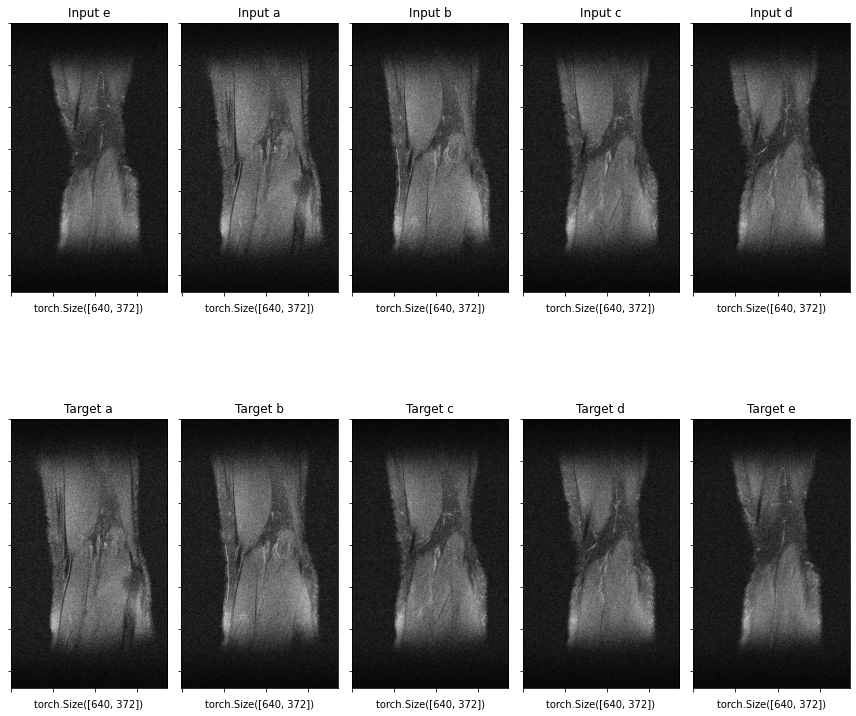

In [23]:
import string
ascii = np.array(list(string.ascii_lowercase))

i            = np.random.randint(len(im_ds))
sandw, label = im_ds[i]
print(f"Sandwich {i} (shape {sandw.shape})")

perm     = sandw_tfm.perms[sandw_tfm.o2i[label]]
perm_arr = np.array(perm)
perm_inv = P.get_inv(perm_arr)

print_line("Permuation")
print("P    ", perm_arr)
print("P Inv", perm_inv)
print("Label", label)

input = ascii[perm_arr]
orig  = input[perm_inv]
letter_pairs = [ascii[perm_arr[i]] + ascii[perm_arr[j]] for i,j in sandw_tfm.pairs]

print_line("Letters")
print("Input", arr2str(input))
print("Orig ", arr2str(orig))
print("Label", list(zip(letter_pairs, label.numpy())))

# plot input sandwich + target slice
n_seq = sandw_tfm.n_seq

# MRs in (magnitude) image space
ims  = toL(sandw) + toL(sandw[perm_inv])
titles  = [f"Input {i}" for i in input] + [f"Target {i}" for i in orig] #range(sandw_tfm.n_seq)]

plot(ims, titles, nrows=2, ncols=sandw_tfm.n_seq, figsize=(12,12))

# Dataloaders

Parameters

In [25]:
bs = 8
num_workers = 2

Define dataloaders (learning in image space)

TODO Data Augs

In [26]:
# Resize??

# sz = (640,372)
# rsz = Resize(sz, method="crop", pad_mode="center")

# T.center_crop??

# # converts complex k-space (2channel) to magnitude-only k-space (1channel)
# class K2ImTfm(Transform):
#   def encodes(self, t:TensorCategory): return t
#   def encodes(self, t:Tensor): return C.apply(t, CenteredTfms.k2im(), post=C.complex2mgn)

In [27]:
class CenterCropTfm(Transform):
  def __init__(self, shape): self.shape = shape
  def encodes(self, t:TensorMultiCategory): return t
  def encodes(self, t:Tensor): return T.center_crop(t, shape=self.shape)

In [28]:
sz = (640,372)

item_tfms  = [CenterCropTfm(sz)]
batch_tfms = [] # partial(C.apply, tfms=C.complex2magn) [IntToFloatTensor] #, k2imTfm, Complex2Channel] # Normalize? SaveShape

im_dls = im_ds.dataloaders(
          after_item  = item_tfms, 
          after_batch = batch_tfms, 
          bs=bs, 
          num_workers = num_workers).cuda()

### Viz dls

Sandwich 797 (shape torch.Size([5, 640, 372]))
**********Permuation**********
P     [2 0 1 4 3]
P Inv [1 2 0 4 3]
Label TensorMultiCategory([1., 1., 0., 0., 0., 0., 0., 0., 0., 1.])
***********Letters************
Input cabed
Orig  abcde
Label [('ca', 1.0), ('cb', 1.0), ('ce', 0.0), ('cd', 0.0), ('ab', 0.0), ('ae', 0.0), ('ad', 0.0), ('be', 0.0), ('bd', 0.0), ('ed', 1.0)]


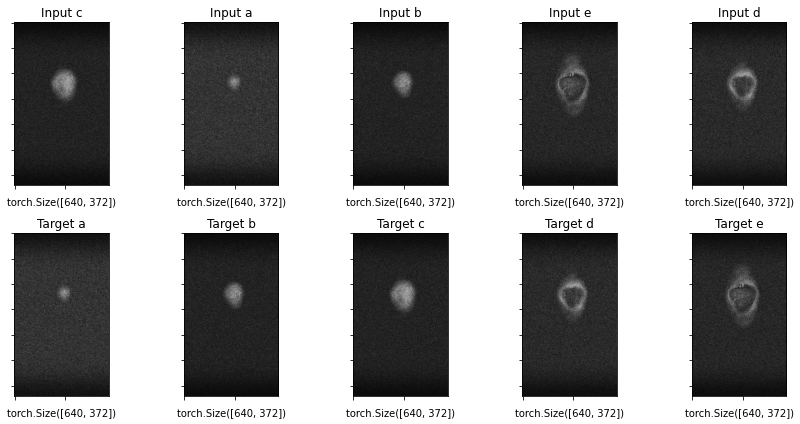

In [37]:
import string
ascii = np.array(list(string.ascii_lowercase))

i            = np.random.randint(len(im_dls.train_ds))
sandw, label = im_dls.train_ds[i]
print(f"Sandwich {i} (shape {sandw.shape})")

perm     = sandw_tfm.perms[sandw_tfm.o2i[label]]
perm_arr = np.array(perm)
perm_inv = P.get_inv(perm_arr)

print_line("Permuation")
print("P    ", perm_arr)
print("P Inv", perm_inv)
print("Label", label)

input = ascii[perm_arr]
orig  = input[perm_inv]
letter_pairs = [ascii[perm_arr[i]] + ascii[perm_arr[j]] for i,j in sandw_tfm.pairs]

print_line("Letters")
print("Input", arr2str(input))
print("Orig ", arr2str(orig))
print("Label", list(zip(letter_pairs, label.numpy())))

# plot input sandwich + target slice
n_seq = sandw_tfm.n_seq

# MRs in (magnitude) image space
ims  = toL(sandw) + toL(sandw[perm_inv])
titles  = [f"Input {i}" for i in input] + [f"Target {i}" for i in orig] #range(sandw_tfm.n_seq)]

plot(ims, titles, nrows=2, ncols=sandw_tfm.n_seq, figsize=(12,6))

In [30]:
#im_dls.train_ds.tfms

# x = im_dls.train_ds

# x.tfms[0].rands
# x.tfms[0].set_rands()
# x.tfms[0].rands

#im_dls.train_ds.tfms

# print(*[(i,lr_dls.train_ds[i][0].shape) for i in range(10)], sep="\n")

# lr_dls.train_ds
# lr_dls.train_ds.tfms -- list of tfms

In [31]:
# xb,yb = im_dls.one_batch()

# Model

In [38]:
# ARCHITECTURE
c_in  = sandw_tfm.n_seq
n_out = c_in * (c_in - 1)//2
arch  = xresnet34(c_in=c_in, n_out=n_out, pretrained=False)

In [39]:
# LOSS FUNC
loss_func = nn.BCEWithLogitsLoss()

In [41]:
# METRICS
def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):
  "Compute accuracy when `inp` and `targ` are the same size."
  if sigmoid: inp = inp.sigmoid()
  return ((inp>thresh)==targ.bool()).float().mean()

accuracy_multi_thresh = partial(accuracy_multi, thresh=0.5)

metrics = [accuracy_multi_thresh]

In [44]:
# CALLBACKS

from fastai2.callback.hook import *

# re-shuffle sandwich for each epoch
class EpochPermute(Callback):
  def begin_epoch(self): sandw_tfm.set_rands()

cbs = [EpochPermute] #ActivationStats(with_hist=True)

In [43]:
# IMPORT/EXPORT WEIGHTS

# save model's trained weights
def export(learn, name, id): 
  learn.export(f"{EXPORT_DIR}/{name}-{id}-export.pkl")

def load(name, id, cpu=False):
  return load_learner(f"{EXPORT_DIR}/{name}-{id}-export.pkl", cpu=cpu)

In [45]:
# LEARNER (TODO: tofp16?)
learn = Learner(im_dls, arch.cuda(), loss_func, metrics=metrics, cbs=cbs)

In [49]:
%time x,y = im_dls.train.one_batch()

CPU times: user 500 ms, sys: 200 ms, total: 700 ms
Wall time: 56.2 s


In [47]:
x.shape, y.shape

(torch.Size([8, 5, 640, 372]), torch.Size([8, 10]))

In [52]:
activs = learn.model(x)
print("Shape", activs.shape)

print_line("Model Activations")
print("Batch Item 0: ", activs[0])
print("Batch Item 0 (sigmoid): ", activs[0].sigmoid())
print("Target Item 0: ", y[0])

#activs.sigmoid()

print_line("Accuracy")
acc0 = accuracy_multi_thresh(activs,y[0])
acc = accuracy_multi_thresh(activs,y)
print("Accuracy Item 0: ", acc0)
print("Batch Accuracy:", acc)

Shape torch.Size([8, 10])
******Model Activations*******
Batch Item 0:  tensor([ 0.3705,  0.0722,  0.6565,  0.5104,  0.1041, -0.2812,  0.5204, -0.1017,
        -0.4821, -0.3520], device='cuda:0', grad_fn=<SelectBackward>)
Batch Item 0 (sigmoid):  tensor([0.5916, 0.5180, 0.6585, 0.6249, 0.5260, 0.4302, 0.6272, 0.4746, 0.3818,
        0.4129], device='cuda:0', grad_fn=<SigmoidBackward>)
Target Item 0:  tensor([1., 1., 1., 1., 1., 0., 0., 0., 0., 1.], device='cuda:0')
***********Accuracy***********
Accuracy Item 0:  tensor(0.6250, device='cuda:0')
Batch Accuracy: TensorMultiCategory(0.6750, device='cuda:0')


# Train

SuggestedLRs(lr_min=0.0005248074419796466, lr_steep=1.5848931980144698e-06)

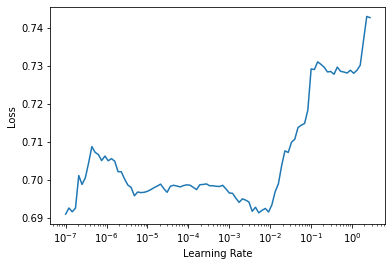

In [53]:
learn.lr_find()

In [54]:
learn.fit_one_cycle(n_epoch=10, lr=3e-3)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.676644,0.652391,0.629707,13:38
1,0.603271,2.119648,0.473437,08:47


KeyboardInterrupt: ignored

In [ ]:
export(learn, "mnist_learn_resnet_no_aug", "epoch5")

# Old

In [ ]:
# indexes into array of kspace slices
class ImSandwP(Transform, P):

  # returns index in fn2attr corresponding to given sandwich
  def sandw2fn_idx(self, i): return np.searchsorted(self.cumsum_n_sandws, i)
  
  # choose which permutation to use for each sandw (to avoid calling random repeatedly)
  def set_rands(self):
    self.rands = np.random.randint(self.c, size=self.total_n_sandws)

  def __init__(self, fn2attr_items, n_seq = 5):

    # permutations
    self.n_seq = n_seq
    self.c     = math.factorial(n_seq)
    self.vocab = CategoryMap([P.arr2str(p) for p in permutations(range(n_seq))])

    # fnames, volumes, slices, sandws, etc
    self.fn2attr_items = fn2attr_items
   
    # how many slices/sandwiches per file
    self.n_slices = [attr["n_slices"] for (_, attr) in self.fn2attr_items]
    self.n_sandws = [n-(self.n_seq-1) for n in self.n_slices]

    # given dataset index, cumsum is used to index into appropriate file
    self.cumsum_n_slices = np.cumsum(self.n_slices)
    self.cumsum_n_sandws = np.cumsum(self.n_sandws)

    # total number of slices/sandwiches in dataset (for reference)
    self.total_n_slices   = self.cumsum_n_slices[-1]
    self.total_n_sandws   = self.cumsum_n_sandws[-1]

    #  choose which permutation to use for each sandw (avoid call to rand repeated)
    self.set_rands()

  def encodes(self, sandw_idx):
    # sandw number (idx 0 = first sandwich = sandwich #1)
    sandw_number = sandw_idx + 1
    
    # get file
    fn_idx  = self.sandw2fn_idx(sandw_number)
    fname   = self.fn2attr_items[fn_idx][0]

    # sandwich index within file
    n_sandw_prior_vol = 0 if fn_idx == 0 else self.cumsum_n_sandws[fn_idx - 1]
    sw_idx  = sandw_idx - n_sandw_prior_vol # 15sandw in file = 14th index
    
    # get kspace sandwich, target slice + neighbor slices on either side
    with h5py.File(fname, 'r') as data:
      ksandw = data['kspace'][sw_idx:sw_idx+self.n_seq]      
    
    # shuffle ksandw according to permutation
    rand     = self.rands[sandw_idx] # rand \in [0,n_seq!]
    perm_str = self.vocab[rand]
    perm_arr = P.str2arr(perm_str)

    ksandw  = T.to_tensor(ksandw[perm_arr])
    imsandw = C.apply(ksandw, CenteredTfms.k2im(), post=C.complex2mgn)

    return imsandw, TensorCategory(rand)

  def decodes(self, o):
    perm_ksandw, perm_category = o
    return perm_ksandw, self.vocab[perm_category]

In [ ]:
# converts complex k-space (2channel) to magnitude-only k-space (1channel)
class K2ImTfm(Transform):
  def encodes(self, t:TensorCategory): return t
  def encodes(self, t:Tensor): return C.apply(t, CenteredTfms.k2im(), post=C.complex2mgn)

In [ ]:
# indexes into array of kspace slices
class SandwP(Transform, P):

  # returns index in fn2attr corresponding to given sandwich
  def sandw2fn_idx(self, i): return np.searchsorted(self.cumsum_n_sandws, i)
  
  # choose which permutation to use for each sandw (to avoid calling random repeatedly)
  def set_rands(self):
    self.rands = np.random.randint(self.c, size=self.total_n_sandws)

  def __init__(self, fn2attr_items, n_seq = 5):

    # permutations
    self.n_seq = n_seq
    self.c     = math.factorial(n_seq)
    self.vocab = CategoryMap([P.arr2str(p) for p in permutations(range(n_seq))])

    # fnames, volumes, slices, sandws, etc
    self.fn2attr_items = fn2attr_items
   
    # how many slices/sandwiches per file
    self.n_slices = [attr["n_slices"] for (_, attr) in self.fn2attr_items]
    self.n_sandws = [n-(self.n_seq-1) for n in self.n_slices]

    # given dataset index, cumsum is used to index into appropriate file
    self.cumsum_n_slices = np.cumsum(self.n_slices)
    self.cumsum_n_sandws = np.cumsum(self.n_sandws)

    # total number of slices/sandwiches in dataset (for reference)
    self.total_n_slices   = self.cumsum_n_slices[-1]
    self.total_n_sandws   = self.cumsum_n_sandws[-1]

    #  choose which permutation to use for each sandw (avoid call to rand repeated)
    self.set_rands()

  def encodes(self, sandw_idx):
    # sandw number (idx 0 = first sandwich = sandwich #1)
    sandw_number = sandw_idx + 1
    
    # get file
    fn_idx  = self.sandw2fn_idx(sandw_number)
    fname   = self.fn2attr_items[fn_idx][0]

    # sandwich index within file
    n_sandw_prior_vol = 0 if fn_idx == 0 else self.cumsum_n_sandws[fn_idx - 1]
    sw_idx  = sandw_idx - n_sandw_prior_vol # 15sandw in file = 14th index
    
    # get kspace sandwich, target slice + neighbor slices on either side
    with h5py.File(fname, 'r') as data:
      ksandw = data['kspace'][sw_idx:sw_idx+self.n_seq]      
    
    # shuffle ksandw according to permutation
    rand     = self.rands[sandw_idx] # rand \in [0,n_seq!]
    perm_str = self.vocab[rand]
    perm_arr = P.str2arr(perm_str)
    return T.to_tensor(ksandw[perm_arr]), TensorCategory(rand)

  def decodes(self, o):
    perm_ksandw, perm_category = o
    return perm_ksandw, self.vocab[perm_category]

In [ ]:
# get batch
show_bs = 3

xb, yb = im_dls.one_batch()
xb, yb = to_cpu(xb)[:show_bs], to_cpu(yb)[:show_bs]
print(f"xb {xb.shape}, yb {yb.shape}")

# magnitude im space
rev_xb = xb #C.apply(xb, C.complex2mgn)
rev_yb = yb #C.apply(yb, C.complex2mgn)

# plot input sandwich + target slice
n_seq = sandw_tfm.n_seq

# MRs in (magnitude) image space - each row = (x slice sequence, HR y)
imspace  = [j for i in range(len(rev_yb)) for j in (*toL(rev_xb[i]), rev_yb[i])]

im_titles = L([f"LR Im {i}" for i in range(n_seq)] + [f"HR Im y ({n_seq//2})"]) * show_bs

ims =  imspace
titles = im_titles

plot(ims, titles, nrows=show_bs, ncols=n_seq+1, figsize=(12,12))